# **Домашнее задание 3. Линейная классификация (base)**

### **Оценивание и штрафы**

С наступающим новым годом, друзья! Магистратура бежит быстро и мы бежим очень быстро, а зима — то время, когда хотелось бы бежать чуть медленнее. Поэтому это домашнее задание мы сделали сильно короче от его начальной версии!

Как всегда, каждая из задач имеет «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

В задании две части:

- Часть 1: написание логистической регрессии своими руками — уверенны, логлосс вы уже знаете как свои пять пальцев.
- Часть 2: решение задачи классификации на текстах.

In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, roc_auc_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
from google.colab import drive # Если вы работаете в коллабе
drive.mount('/content/drive')

Mounted at /content/drive


# **Часть 1. Логистическая регрессия своими руками (5 баллов)**

Логистическая регрессия — безумно важная и удобная модель для понимания начальных концепций. Вы много практиковались с выведением формулы градиента логлосса, шага спуска, а в прошлом дз сделали SGD. Давайте сделаем ещё шаг вперед — и реализуем логистическую регрессию своими руками.

На практике, часто хватает алгоритмов из коробки. Но иногда очень удобно сделать свой алгоритм.

## **Теоретическая сноска: почему LogLoss'а так много**

Почти наверное (в математике это значит, во всех случаях, кроме множества размером 0) логлосс набил оскомину за несколько заданий. Давайте посмотрим на него ещё раз:

В логистической регрессии функция потерь

$$\text{LogLoss}(y, \hat{p}) = -\left(y\log \hat{p} + (1-y)\log (1-\hat{p})\right)$$

Зачем мы так долго с ней возимся?

#### **Пункт 1.**
Во-первых, это **следствие максимизации правдоподобия** при биномиальной модели.

Если считать, что целевая переменная (Y\in{0,1}) распределена как

$$P(Y=1 \mid x) = \hat{p}(x), \qquad P(Y=0\mid x) = 1-\hat{p}(x),$$
то правдоподобие выборки ( (x_i, y_i) )\ равно
$$L = \prod_{i=1}^n \hat{p}_i^{y_i}(1-\hat{p}_i)^{1-y_i}.$$

Максимизация $\log L$ эквивалентна минимизации LogLoss.
Таким образом, LogLoss — **единственная функция потерь, полностью согласованная с вероятностной моделью логистической регрессии**.

#### **Пункт 2.**

Во-вторых, логлосс поможет нам в будущем понять другие функции потерь. Так, например LogLoss является частным случаем **кросс-энтропии между истинным распределением и предсказанным**.

Для двух распределений $p$ (истинного) и $q$ (предсказанного) кросс-энтропия определяется как

$$H(p,q) = -\sum_{k} p(k)\log q(k).$$

В бинарном случае истинное распределение дискретно:

$$p = (y, 1-y), \qquad q = (\hat{p}, 1-\hat{p}),$$
и подстановка даёт

$$H(p,q) = -\left[y\log \hat{p} + (1-y)\log (1-\hat{p})\right] = \text{LogLoss}.$$


В общем, любим, жалуем и реализуем.




### **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1.5 балла). Градиентного спуска**

**Задание 1.2 (1.5 балла). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [ ]:
import numpy as np
from math import exp
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = []

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """

        if self.w0 is None:
            self.w0 = np.zeros(X.shape[1])

        self.w = self.w0.copy()

        for i in range(self.max_iter):
            loss = self.calc_loss(X, y)

            if self.gd_type == 'full':
                gradients = self.calc_gradient(X, y)
            else:
                index = np.random.randint(0, X.shape[0])
                gradients = self.calc_gradient(X[index:index + 1], y[index:index + 1])

            self.loss_history.append(loss)
            updated_w = self.w - self.eta * gradients

            if np.linalg.norm(updated_w - self.w) < self.tolerance:
                break

            self.w = updated_w

        return self

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        return self.sigmoid(X @ self.w)


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)


    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        # В качестве лосса тут рассматриваем LogLoss !

        pred = self.sigmoid(X @ self.w)
        return (1 / X.shape[0]) * (X.T @ (pred - y))


    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        proba = self.sigmoid(X @ self.w)
        return -np.mean(y * np.log(proba) + (1 - y) * np.log(1 - proba))


Теперь проверим работу вашего класса на синтетических данных.

In [ ]:
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=2,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Задание 2 (0.6 балла)**

Теперь давайте тестировать модель.
1. Обучите свою логистическую регрессию на синтетических данных (0.2 балла) — на полном GD и SGD;
2. Cравните результат с моделью из библиотеки. Посчитайте roc-auc, accuracy, постройте ROC и PR кривые. , оцените разницу в производительности моделей по метрикам качества. Ответьте на вопросы:
- Какая показывает лучший результат? Почему?
- Есть ли что-то в модели из коробки, что по умолчанию делает её не равной вашей модели? Для ответа на этот вопрос вам может пригодитться [документация](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Её мы изучаем всегда, чтобы понимать тонкости реализации какого-либо метода в библиотеке. (0.4 балла)

In [ ]:
lr_sgd = LogReg(gd_type='stochastic')
lr_sgd.fit(X_train, y_train)

lr_full = LogReg(gd_type='full')
lr_full.fit(X_train, y_train)


LogReg(gd_type='full',
       w0=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

lr_lib = LogisticRegression()
lr_lib.fit(X_train, y_train)

y_sgd = lr_sgd.predict(X_test)
print(f'Stochastic Gradient Descent: ROC-AUC={roc_auc_score(y_test, y_sgd)}, Accuracy={accuracy_score(y_test, y_sgd)}')

y_full = lr_full.predict(X_test)
print(f'Full Gradient Descent: ROC-AUC={roc_auc_score(y_test, y_full)}, Accuracy={accuracy_score(y_test, y_full)}')

y_lib = lr_lib.predict(X_test)
print(f'Library Model: ROC-AUC={roc_auc_score(y_test, y_lib)}, Accuracy={accuracy_score(y_test, y_lib)}')

Stochastic Gradient Descent: ROC-AUC=0.8613250629647292, Accuracy=0.8613
Full Gradient Descent: ROC-AUC=0.8660576072055748, Accuracy=0.8660333333333333
Library Model: ROC-AUC=0.8681011072682042, Accuracy=0.8681


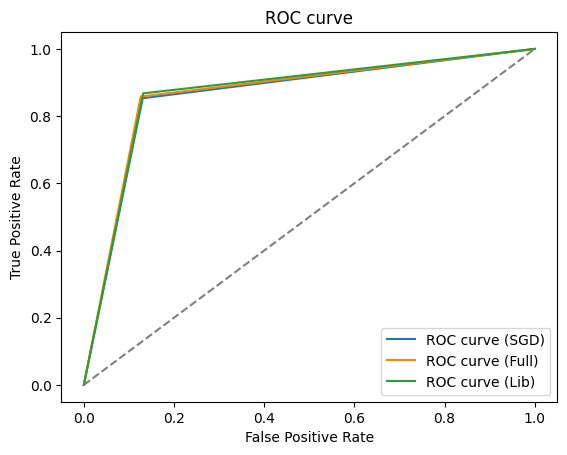

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_sgd)
fpr_full, tpr_full, _ = roc_curve(y_test, y_full)
fpr_lib, tpr_lib, _ = roc_curve(y_test, y_lib)
plt.plot(fpr_sgd, tpr_sgd, label='ROC curve (SGD)')
plt.plot(fpr_full, tpr_full, label='ROC curve (Full)')
plt.plot(fpr_lib, tpr_lib, label='ROC curve (Lib)')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

/tmp/ipython-input-2389852823.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


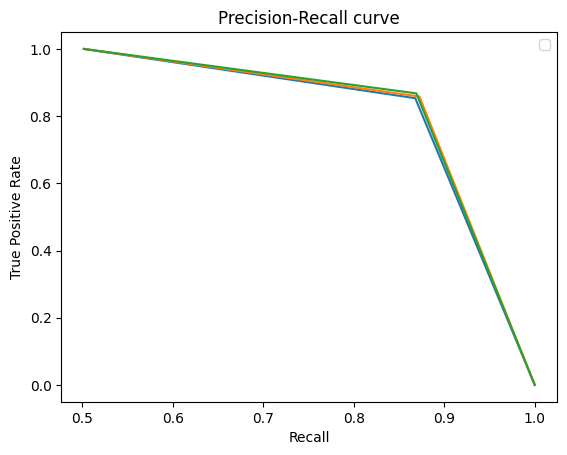

In [ ]:
precision_sgd, recall_sgd, _ = precision_recall_curve(y_test, y_sgd)
precision_full, recall_full, _ = precision_recall_curve(y_test, y_full)
precision_lib, recall_lib, _ = precision_recall_curve(y_test, y_lib)
plt.plot(precision_sgd, recall_sgd)
plt.plot(precision_full, recall_full)
plt.plot(precision_lib, recall_lib)
plt.xlabel('Recall')
plt.ylabel('True Positive Rate')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

### Качества моделей
Все три модели показывает достаточно близкие и высокие результаты, если судить по метрикам ROC-AUC и Accuracy, но все же модель из коробки показывает немного лучшее качество по сравнению с моей реализацией.

### Преимущества модели из коробки
1) sklearn.linear_model.LogisticRegression по умолчанию использует L2-регуляризатор. моя модель лишена данной особенности

2) Насколько я понял, модель из коробки использует другие методы оптимизации: ‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’. Моя реализация включает только два метода градиентного спуска - полный и стохастический

### **Задание 3 (0.4 балла)**

Для трех полученных моделей, визуализируйте прогнозы по данным на тестовой выборке. Для этого:
- получите прогнозы;
- сомжите данные, используя PCA. Не забудьте, что PCA полагает нулевое среднее и единичную дисперсию;
- покрасьте данные по прогнозам.

Как различаются графики для трёх моделей? И различаются ли?

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)

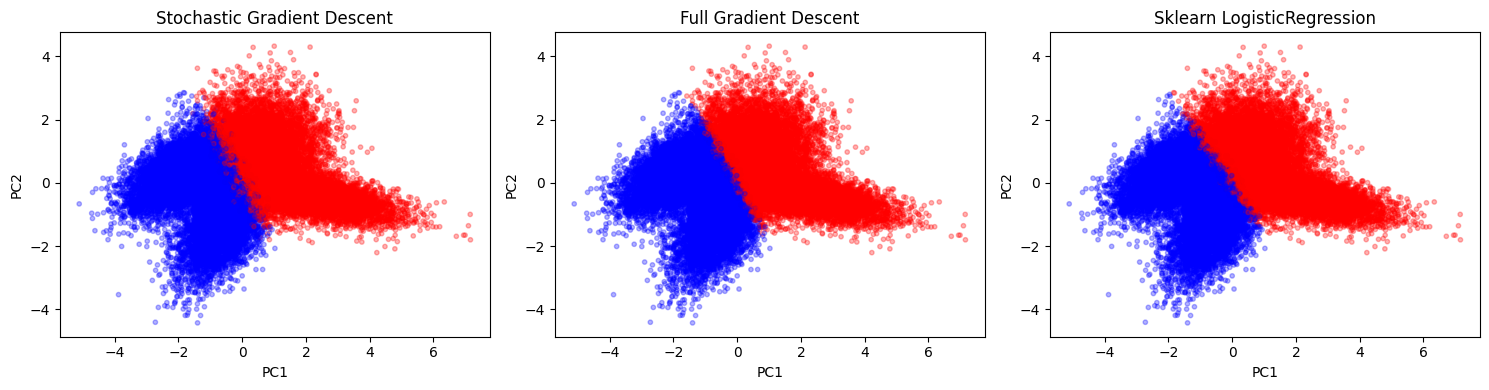

In [ ]:
plt.figure(figsize=(15, 4))

for i, (y_pred, title) in enumerate([
    (y_sgd, 'Stochastic Gradient Descent'),
    (y_full, 'Full Gradient Descent'),
    (y_lib, 'Sklearn LogisticRegression')
]):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, cmap='bwr', alpha=0.3, s=10)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
plt.tight_layout()
plt.show()

### Описание графиков

Графики по трем прогнозам очень похожи между собой, однако у графиха модели со стохастическим спуском наблюдается более размытая граница между классами.

У модели из коробки и модели с полным градиентным спуском граница обозначена четче.

# **Часть 2. Обучение моделей на текстовых данных. (5 баллов)**

 ### **Подготовка данных из реального мира.**

Ещё одна прелесть простых моделей — возможность решать с ними неструктурированные (изначально не табличные) задачи. Давайте посмотрим на это в действии на примере текстов.


Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [ ]:
from sklearn.model_selection import train_test_split

PATH = 'train.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (1.5 балла).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой (0.2 балла).

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
data = data.fillna('')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


- Проанализируйте количество уникальных значений в столбцах, опустив `text`. Сделайте выводы. (0.5 балла)

In [ ]:
data.nunique()

,0
id,7613
keyword,222
location,3342
text,7503
target,2


### Выводы

id - уникальный идентификатор для каждого объекта, можем удалить из выборки, так как не влияет на целевую переменную

keyword - немного уникальных значений относительно количества объектов в выборке

location - имеет больше уникальных значений, чем количество выборки, деленное пополам. Привычное OneHot-кодирование тут не подойдет, нужно придумывать что-то другое.

target - целевая переменная при бинарной классификации

- Проанализируйте соотношение классов в целевой переменной. Какое оно? Выберите метрику, с помощью которой будете оценивать модель.  (0.5 балла)

In [ ]:
print(f'Нулевой класс: {data[data['target'] == 0].shape[0]} объектов')
print(f'Единичный класс: {data[data['target'] == 1].shape[0]} объектов')

Нулевой класс: 4342 объектов
Единичный класс: 3271 объектов


In [ ]:
print(f'Нулевой класс содержит больше объектов и составляет {data[data['target'] == 0].shape[0] / data.shape[0] * 100}% от всей выборки')

Нулевой класс содержит больше объектов и составляет 57.03402075397347% от всей выборки


### Метрика

Буду использовать метрику ROC-AUC

- Объедините все три текстовых столбца в один для baseline (вам поможет конкатенация строк) (0.3 балла)

In [ ]:
data_new = data[['id', 'target']].copy()
data_new['text'] = data['keyword'] + data['location'] + data['text']
data_new.head()

,id,target,text
0,1,1,Our Deeds are the Reason of this #earthquake M...
1,4,1,Forest fire near La Ronge Sask. Canada
2,5,1,All residents asked to 'shelter in place' are ...
3,6,1,"13,000 people receive #wildfires evacuation or..."
4,7,1,Just got sent this photo from Ruby #Alaska as ...


- Наконец, поделите данные на тренировочную и тестовую выборки. (0.2 балла)

In [ ]:
X = data_new['text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества и насколько разнообразны данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица? (0.3 балла)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_scaled = count_vectorizer.fit_transform(X_train)
X_test_scaled = count_vectorizer.transform(X_test)
print(f'Размер тренировочной матрицы: {X_train_scaled.shape}')
print(f'Размер тестовой матрицы: {X_test_scaled.shape}')

Размер тренировочной матрицы: (5329, 22738)
Размер тестовой матрицы: (2284, 22738)


- Обучите логистическую регрессию на полученном наборе. Модель возьмите из библиотеки. Какое качество по выбранной вами метрике у модели получилось на тестовых данных? (0.3 балла)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
y_pred = log_reg.predict(X_test_scaled)
print(f'ROC-AUC на тестовой выборке (LogReg): {roc_auc_score(y_test, y_pred)}')

ROC-AUC на тестовой выборке (LogReg): 0.7898927731018514


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.(0.4 балла)

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_scaled, y_train)

SVC()

In [ ]:
y_svc_pred = svc.predict(X_test_scaled)
print(f'ROC-AUC на тестовой выборке (SCV): {roc_auc_score(y_test, y_svc_pred)}')

ROC-AUC на тестовой выборке (SCV): 0.7785574479181393


### Анализ качества и скорости обучения
LogisticRegression показывает более эффективные показатели при обучении, чем SVC, который обучается дольше.

Кроме того, SVC показал более низкие результаты по метрике ROC-AUC на тестовой выборке

### **Задание 12. Улучшение базовых моделей за счет данных. (0.3 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют.

Обучайте и логистическую регрессию, и SVC.

In [ ]:
count_vectorizer = CountVectorizer(
    max_features=X_train.shape[0] // 4,
    min_df=3,
    max_df=0.8
)
X_train_smart_scaled = count_vectorizer.fit_transform(X_train)
X_test_smart_scaled = count_vectorizer.transform(X_test)
print(f'Размер тренировочной матрицы: {X_train_smart_scaled.shape}')
print(f'Размер тестовой матрицы: {X_test_smart_scaled.shape}')

Размер тренировочной матрицы: (5329, 1332)
Размер тестовой матрицы: (2284, 1332)


In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_smart_scaled, y_train)

LogisticRegression()

In [ ]:
y_smart_pred = log_reg.predict(X_test_smart_scaled)
print(f'ROC-AUC на тестовой выборке (LogReg Smart Scaled): {roc_auc_score(y_test, y_smart_pred)}')

ROC-AUC на тестовой выборке (LogReg Smart Scaled): 0.780199781964643


In [ ]:
svc = SVC()
svc.fit(X_train_smart_scaled, y_train)

SVC()

In [ ]:
y_svc_smart_pred = svc.predict(X_test_smart_scaled)
print(f'ROC-AUC на тестовой выборке (SCV): {roc_auc_score(y_test, y_svc_smart_pred)}')

ROC-AUC на тестовой выборке (SCV): 0.7733846062011266


## Подобранные гиперпараметры

- max_features - верхнее ограничение на число признаков после векторизации
- min_df - отбрасывание слов, которые встречались менее 3 раз (снижение уровня шума)
- max_df - отбрасывание слов, которые встречаются более чем в 80% объектов (снижение уровня шума)

### **Задание 13. Улучшение базовых моделей за счет данных 2. (0.7 балла).**

В первом пункте мы склеили все строки в одну. Но можно было бы поступить иначе — и получить категории из `'keyword', 'location'`. Протестируйте такой подход на обеих моделях и замерьте качество. Улучшает ли это результат?

In [ ]:
X = data[['text', 'keyword', 'location']]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

,text,keyword,location
1186,Ashes 2015: AustraliaÛªs collapse at Trent Br...,bridge%20collapse,
4071,GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,hail,"Carol Stream, Illinois"
5461,CNN: Tennessee movie theater shooting suspect ...,police,Houston
5787,Still rioting in a couple of hours left until ...,rioting,
7445,Crack in the path where I wiped out this morni...,wounds,Lake Highlands


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

vectorizer = CountVectorizer(
    max_features=X_train.shape[0] // 4,
    min_df=3,
    max_df=0.8
)
X_train_text = vectorizer.fit_transform(X_train['text'])

ohe_location = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
ohe_keyword = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train_keyword = ohe_location.fit_transform(X_train[['keyword']])
X_train_location = ohe_keyword.fit_transform(X_train[['location']])

X_train_modified = hstack([X_train_text, X_train_keyword, X_train_location])
X_train_modified.shape

(5329, 4025)

In [ ]:
X_test_text = vectorizer.transform(X_test['text'])
X_test_keyword = ohe_location.transform(X_test[['keyword']])
X_test_location = ohe_keyword.transform(X_test[['location']])

X_test_modified = hstack([X_test_text, X_test_keyword, X_test_location])
X_test_modified.shape

(2284, 4025)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_modified, y_train)

LogisticRegression()

In [ ]:
y_modified_pred = log_reg.predict(X_test_modified)
print(f'ROC-AUC на тестовой выборке (LogReg OHE + CountVectorizer): {roc_auc_score(y_test, y_modified_pred)}')

ROC-AUC на тестовой выборке (LogReg Smart Scaled): 0.7826495380100975


In [ ]:
svc = SVC()
svc.fit(X_train_modified, y_train)

SVC()

In [ ]:
y_modified_pred = svc.predict(X_test_modified)
print(f'ROC-AUC на тестовой выборке (SVC OHE + CountVectorizer): {roc_auc_score(y_test, y_modified_pred)}')

ROC-AUC на тестовой выборке (SVC OHE + CountVectorizer): 0.7820455423708045


### Улучшает ли результат

После использования CountVectorizer на признаке text и OneHot Encoding для keyword и location метрика ROC-AUC показывает более высокие показатели, как для LogisticRegression, так и для SVC, по сравнению с применением только CountVectorizer с подобранными гиперпараметрами.

При использовании CountVectorizer с параметрами по умолчанию на конкатенированном text я получил лучшее качество на LogisticRegression, но худшее на SVC.

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
}

lr = LogisticRegression(max_iter=1000, penalty='l2')
grid = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=3)
grid.fit(X_train_modified, y_train)

print(f'Лучшие параметры: {grid.best_params_}')
print(f'Лучшее качество (ROC-AUC): {grid.best_score_}')

Лучшие параметры: {'C': 0.1, 'solver': 'liblinear'}
Лучшее качество (ROC-AUC): 0.8418875678979735


In [ ]:
lr_chosen = LogisticRegression(max_iter=1000, penalty='l2', C=0.1, solver='liblinear')
lr_chosen.fit(X_train_modified, y_train)

y_pred = lr_chosen.predict(X_test_modified)
roc_auc_score(y_test, y_pred)

np.float64(0.7828105511519117)

### Итог
Получили немного лучшее качество, чем на предыдущем этапе без подбора гиперпараметров
- C = 0.1 (параметр регуляризации)
- solver = liblinear (метод оптимизации параметров)


- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear'],
}

svc = SVC(probability=True)
grid = GridSearchCV(svc, param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train_modified, y_train)

print(f'Лучшие параметры: {grid.best_params_}')
print(f'Лучшее качество (ROC-AUC): {grid.best_score_}')

Лучшие параметры: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Лучшее качество (ROC-AUC): 0.8442120100808544


In [ ]:
svc_chosen = SVC(probability=True, C=1, gamma='scale', kernel='rbf')
svc_chosen.fit(X_train_modified, y_train)

y_pred = svc_chosen.predict(X_test_modified)
roc_auc_score(y_test, y_pred)

np.float64(0.7820455423708045)

# Итог
лучшее качество получается при выборе гиперпарамтров по умолчанию (судя по документации GridSearch выдал именно их)

Соответственно качество SVC не улучшилось с прошлого этапа, а осталось таким же.

Ваши выводы здесь.

### **Задание 14. (0.5 балла)**

Оформите два [пайплайна](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

cat_features = ['keyword', 'location']
text_features = ['text']

preprocessor = ColumnTransformer(
    [
        (
            'cat',
            Pipeline(
                [
                    ('impute', SimpleImputer(strategy='constant', fill_value='')),
                    ('ohe', OneHotEncoder(sparse_output=True, handle_unknown='ignore')),
                ]
            ),
            cat_features,
        ),
        (
            'text',
            Pipeline(
                [
                    ('vec', CountVectorizer()),
                ]
            ),
            text_features[0]
        )
    ]
)

lr_pipe = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', LogisticRegression(max_iter=1000, penalty='l2', C=0.1, solver='liblinear')),
    ]
)

svc_pipe = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('model', SVC(probability=True, C=1, gamma='scale', kernel='rbf')),
    ]
)

In [ ]:
X = data[['text', 'keyword', 'location']]
y = data['target']

,text,keyword,location
1186,Ashes 2015: AustraliaÛªs collapse at Trent Br...,bridge%20collapse,
4071,GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,hail,"Carol Stream, Illinois"
5461,CNN: Tennessee movie theater shooting suspect ...,police,Houston
5787,Still rioting in a couple of hours left until ...,rioting,
7445,Crack in the path where I wiped out this morni...,wounds,Lake Highlands


In [ ]:
lr_pipe.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['keyword', 'location']),
                                                 ('text',
                                                  Pipeline(steps=[('vec',
                                                                   CountVectorizer())]),
                                                  'text')])),
                ('model',
                 LogisticRegression(C=0.1, max_iter=1000, solver='liblinear'))])

In [ ]:
svc_pipe.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['keyword', 'location']),
                                                 ('text',
                                                  Pipeline(steps=[('vec',
                                                                   CountVectorizer())]),
                                                  'text')])),
                ('model', SVC(C=1, probability=True))])


**Опишите общие мысли о работе. Это место для вашей рефлексии, не обязательное, но полезное.**  🐤

Очень интересно было поработать самостоятельно над реализацией LogisticRegression, порыться в документации насчет того, чем моя реализация отличается от библиотечной.

Постепенно привыкаю наблюдать за тем, что при изменении гиперпараметров или использовании методов для изменения параметров, целевая метрика изменяется на тысячные доли.